This notebook presents a baseline neural approach for text classification using an LSTM architecture. Experiments are conducted on the IMDb dataset to validate the modeling pipeline before applying the same methodology to legal court decision texts.

#load IMDb dataset

In [1]:
pip install kagglehub[pandas-datasets]

In [2]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews") #@param {type: "string"}

# Creating file path
csv_path = os.path.join(path, "IMDB Dataset.csv")


# Encoding = 'latin-1' tells pandas that there could be different chracters in th file.
df = pd.read_csv(csv_path, encoding='latin-1')

print("First 5 records:")
df.head()

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
First 5 records:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Explanatory Data Analysis (EDA)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Checking the distribution of classes
class_counts = df['sentiment'].value_counts()
print(class_counts)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
# Checking the statistics about reviews
# Calculating num of tokens on each line
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

print("Statistics about reviews:")
print(df['word_count'].describe())

print("\n%90 are below this length:", np.percentile(df['word_count'], 90))
print("%95 are below this length:", np.percentile(df['word_count'], 95))
print("%99 are below this length:", np.percentile(df['word_count'], 99))

Statistics about reviews:
count    50000.000000
mean       231.162560
std        171.351613
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64

%90 are below this length: 451.0
%95 are below this length: 590.0
%99 are below this length: 908.0


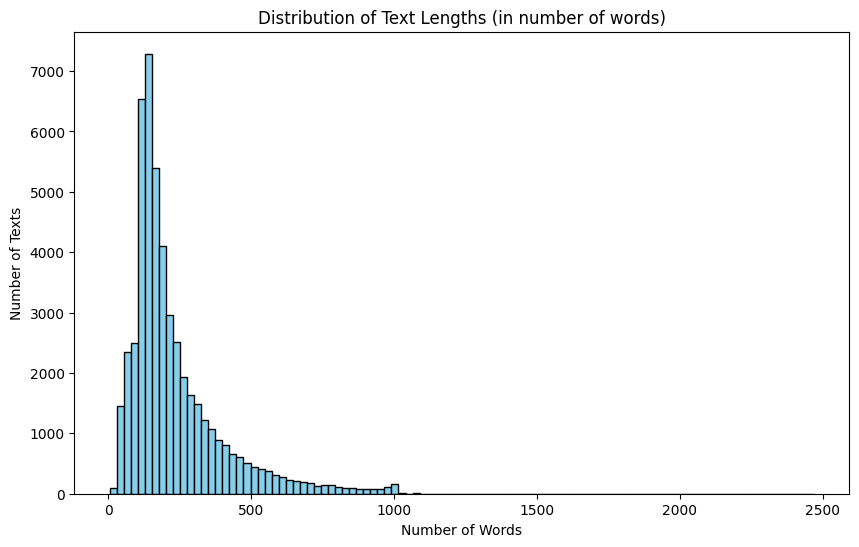

In [6]:
# Visualizing the results
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths (in number of words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.show()

# Text Preprocessing and Normalization

Removing HTML Tags

In [7]:
import re
import string
from nltk.tokenize import word_tokenize
import nltk

In [8]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
def clean_text(text: str) -> str:
    """
    This function clears review column of the dataset by removing HTML tags and
    all non words. It finally turns all letters lowercase.

    @param text: The raw review string to be cleaned.
    @return: The cleaned string.
    """
    assert isinstance(text, str), (
        f"Expected input of type str, but got {type(text).__name__}"
    )

    # Replacing HTML tags with a space
    text = re.sub(r'<.*?>', ' ', text)

    # Replaces all punctuation characters with a space
    text = re.sub(r"[^\w\s']", ' ', text)

    # Lowercase
    text = text.lower()

    return text

# Applying the cleaning function
df['clean_review'] = df['review'].apply(clean_text)

# Tokenize the cleaned text
df['tokens'] = df['clean_review'].apply(word_tokenize)

Removing stopwords

In [10]:
from nltk.corpus import stopwords

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
stop_words = set(stopwords.words('english'))

non_stop_words = ["not","no","nor"]

stop_words -= set(non_stop_words)

df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Check
print("First 5 records after stopwords cleanup:")
print(df['tokens'].head())

First 5 records after stopwords cleanup:
0    [one, reviewers, mentioned, watching, 1, oz, e...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, 's, family, little, boy, jake, thi...
4    [petter, mattei, 's, love, time, money, visual...
Name: tokens, dtype: object


#Label Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
label_encoder = LabelEncoder()

df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Checking which index corresponds to which label
print(label_encoder.classes_)

['negative' 'positive']


vectorizing each word

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
# Tokenizer Settings
# num_words=10000: Only care about most frequent 10.000 words, discard the rest.
# oov_token="<OOV>": Tag to be used for unkown words (Out Of Vocabulary).
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Creating vocabulary
# This is the "learning" phase. Tokenizer scans through entire df['tokens'] column (all 50,000 reviews).
# It finds every unique word.
# It counts how many times each word appears.
# It sorts them by popularity (Frequency).
# It assigns the number 1 to the most common word, 2 to the second most common, etc.
tokenizer.fit_on_texts(df['tokens'])

Sequence Conversion

In [17]:
# fit_on_texts was writing the dictionary, texts_to_sequences is actually using
# that dictionary to translate reviews from English into "Numbers".
df['sequences'] = tokenizer.texts_to_sequences(df['tokens'])

# Check
print(df['sequences'].head())

0    [7, 1933, 939, 63, 203, 2987, 292, 138, 3072, ...
1    [287, 47, 251, 1256, 2850, 1, 69, 12, 2136, 14...
2    [99, 287, 29, 1030, 12, 753, 1348, 2478, 1115,...
3    [565, 2, 130, 47, 295, 3249, 1124, 2, 881, 413...
4    [1, 1, 2, 40, 12, 188, 2011, 1299, 4, 33, 333,...
Name: sequences, dtype: object


In [18]:
print(df[['tokens', 'sequences']].head())

                                              tokens  \
0  [one, reviewers, mentioned, watching, 1, oz, e...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, 's, family, little, boy, jake, thi...   
4  [petter, mattei, 's, love, time, money, visual...   

                                           sequences  
0  [7, 1933, 939, 63, 203, 2987, 292, 138, 3072, ...  
1  [287, 47, 251, 1256, 2850, 1, 69, 12, 2136, 14...  
2  [99, 287, 29, 1030, 12, 753, 1348, 2478, 1115,...  
3  [565, 2, 130, 47, 295, 3249, 1124, 2, 881, 413...  
4  [1, 1, 2, 40, 12, 188, 2011, 1299, 4, 33, 333,...  


#Padding

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
max_length = 600

# Padding
# padding='post': Add 0s to the end of sentences
# truncating='post': If sentence is longer than 600 crop
X = pad_sequences(df['sequences'], maxlen=max_length, padding='post', truncating='post')

print("Data shape after padding:", X.shape)

Data shape after padding: (50000, 600)


#Splitting Dataset

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
print(df.head())

                                              review sentiment  word_count  \
0  One of the other reviewers has mentioned that ...  positive         307   
1  A wonderful little production. <br /><br />The...  positive         162   
2  I thought this was a wonderful way to spend ti...  positive         166   
3  Basically there's a family where a little boy ...  negative         138   
4  Petter Mattei's "Love in the Time of Money" is...  positive         230   

                                        clean_review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production    the filming t...   
2  i thought this was a wonderful way to spend ti...   
3  basically there's a family where a little boy ...   
4  petter mattei's  love in the time of money  is...   

                                              tokens  sentiment_encoded  \
0  [one, reviewers, mentioned, watching, 1, oz, e...                  1   
1  [wonderful, little, production, filming, 

In [23]:
y = df['sentiment_encoded']

# Splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Splitting validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

Training: 72% (36,000 reviews)\
Validation: 8% (4,000 reviews)\
Test: 20% (10,000 reviews)

# Model Architecture

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional

In [25]:

vocab_size = 10000 #@param {type:"integer"}
embedding_dim = 64 #@param {type:"integer"} Each word will be represented by a vector with length 64
max_length = 600 #@param {type:"integer"}

# Buildingthe LSTM model
model = Sequential()
# First laye is Embedding.
# input_dim = Vocabulary Size
# output_dim = The size of the vector representing each word
# input_length = Max sentence length
# mask_zero=True flag is telling the LSTM to skip trailing zeros.
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, mask_zero=True))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
model.add(Bidirectional(LSTM(units=64, return_sequences=False, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training the Model

In [27]:
num_epochs = 5 #@param {type:"integer"}
model.fit(X_train, y_train, epochs= num_epochs,validation_data=(X_val, y_val), batch_size=32)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.7731 - loss: 0.4501 - val_accuracy: 0.8867 - val_loss: 0.2774
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9234 - loss: 0.2017 - val_accuracy: 0.8848 - val_loss: 0.2785
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9449 - loss: 0.1502 - val_accuracy: 0.8835 - val_loss: 0.2978
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.9626 - loss: 0.1047 - val_accuracy: 0.8730 - val_loss: 0.3372
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.9770 - loss: 0.0699 - val_accuracy: 0.8848 - val_loss: 0.3850


Testing the Model

In [28]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Accurracy: %{accuracy * 100:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8869 - loss: 0.3687
Test Accurracy: %88.75


# Visualizing the Results

In [29]:
from sklearn import metrics

In [30]:
y_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_prob >= 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


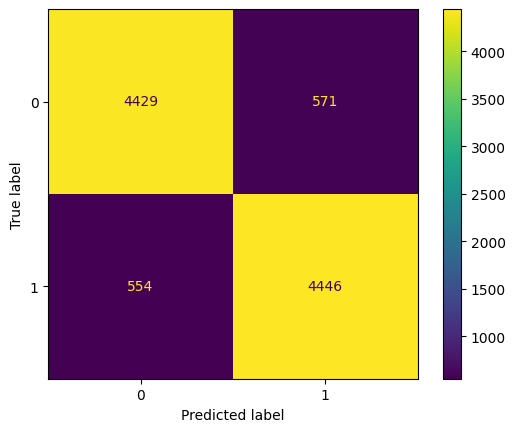

In [31]:
# Creating the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Displaying the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()

The confusion matrix indicates that the baseline model performs in a balanced manner
across both classes. The number of false positives and false negatives is comparable,
suggesting that the model does not exhibit a strong bias toward either class.

Although the overall accuracy is relatively high, misclassifications remain significant.
This is expected, as the model relies on surface-level textual features and does not
capture sequential or contextual dependencies within the text.

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5000
           1       0.89      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Precision, recall, and F1-score values further confirm that the model achieves
comparable performance across both classes.


# Optional: Inference Example

In [35]:
def predict_sentiment(text: str) -> dict:
    """
    Performs sentiment prediction on a single input text
    using the trained LSTM model.

    @param text (str): Raw input review text.

    @return dict: Predicted label and confidence score.
    """
    assert isinstance(text, str), "Input text must be a string"
    assert text.strip() != "", "Input text must not be empty"

    # Text preprocessing
    cleaned_text = clean_text(text)

    # Tokenization
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(
        sequence,
        maxlen=max_length,
        padding="post",
        truncating="post"
    )

    # Model prediction
    prediction = model.predict(padded_sequence, verbose=0)[0][0]

    label = "positive" if prediction >= 0.5 else "negative"

    return {
        "label": label,
        "confidence": float(prediction)
    }

Example usage

In [42]:
sample_review = """
The movie was slow and predictable, but the acting was surprisingly good.
Overall my review is that it wasn't good enough.
"""

result = predict_sentiment(sample_review)

print("Predicted sentiment:", result["label"])
print("Confidence score:", result["confidence"])


Predicted sentiment: negative
Confidence score: 0.48347046971321106
